In [1]:
import sys, os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
sys.path.append("../")

In [3]:
from Transformers import UNetDataset, ChannelsFirst, ToTensor, Rescale

In [4]:
DATA_DIR_DEEPTHOUGHT="/storage/yw18581/data"
data_dir = DATA_DIR_DEEPTHOUGHT
train_test = os.path.join(data_dir, "train_validation_test")

In [5]:
data = np.load("/storage/yw18581/data/train_validation_test/Xy_train+val_clean_300_24_10_25.npz")
x = data["x"]
y = data['y']
dist = data['dist']
class_dist = np.unique(data['dist'], return_inverse=True)[1]

In [6]:
composed = transforms.Compose([Rescale(.25), ChannelsFirst(), ToTensor()])

In [7]:
train_dataset = UNetDataset(x, y, transform=composed, dist = dist[...,np.newaxis])

In [8]:
data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

In [9]:
torch.cuda.empty_cache() 

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
from cUNet_pytorch_pooling import cUNet, dice_loss

In [12]:
model = cUNet(out_size=1)

In [13]:
criterion_mask = dice_loss

In [14]:
criterion_class = nn.MSELoss()

In [15]:
model.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [16]:
import torch.optim as optim


optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
epochs = 50

In [18]:
coeff_mask = 0.60

In [19]:
for epoch in range(epochs):
    print("Epoch {}\n".format(epoch+1))
    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        inputs = batch['image'].float().to(device)
        labels_mask = batch['mask'].float().to(device)
        labels_dist = batch['dist'].float().to(device)
        #print(inputs.is_cuda, labels_mask.is_cuda, labels_dist.is_cuda)
        optimizer.zero_grad()
        out_mask, out_class  = model(inputs)
        #print(out_mask.is_cuda)
        #print(out_class.is_cuda)
        loss_mask = criterion_mask(out_mask, labels_mask)
        loss_class = criterion_class(out_class, labels_dist)
        loss = coeff_mask * loss_mask + (1-coeff_mask) * loss_class
        #print(loss_mask, loss_class)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 60 == 59:    # print every 2000 mini_batches
            print('[%d, %5d] loss: %.3f' % 
                 (epoch + 1, i + 1, running_loss / 60))
print('Finished Training')

Epoch 1

[1,    60] loss: 41.756
Epoch 2

[2,    60] loss: 32.851
Epoch 3

[3,    60] loss: 32.840
Epoch 4

[4,    60] loss: 33.441
Epoch 5

[5,    60] loss: 32.365
Epoch 6

[6,    60] loss: 32.802
Epoch 7

[7,    60] loss: 32.479
Epoch 8

[8,    60] loss: 32.151
Epoch 9

[9,    60] loss: 32.924
Epoch 10

[10,    60] loss: 32.157
Epoch 11

[11,    60] loss: 30.749
Epoch 12

[12,    60] loss: 13.505
Epoch 13

[13,    60] loss: -0.151
Epoch 14

[14,    60] loss: -0.309
Epoch 15

[15,    60] loss: -0.422
Epoch 16

[16,    60] loss: -0.495
Epoch 17

[17,    60] loss: -0.522
Epoch 18

[18,    60] loss: -0.527
Epoch 19

[19,    60] loss: -0.533
Epoch 20

[20,    60] loss: -0.535
Epoch 21

[21,    60] loss: -0.528
Epoch 22

[22,    60] loss: -0.532
Epoch 23

[23,    60] loss: -0.521
Epoch 24

[24,    60] loss: -0.540
Epoch 25

[25,    60] loss: -0.538
Epoch 26

[26,    60] loss: -0.541
Epoch 27

[27,    60] loss: -0.543
Epoch 28

[28,    60] loss: -0.543
Epoch 29

[29,    60] loss: -0.538
Epo

In [20]:
model_name = "../model/trained_cUNet_pytorch_regression_{}epochs_coeff_mask{}.pkl".format(epochs, coeff_mask)

In [21]:
torch.save(model.state_dict(), model_name)

In [22]:
model_inference = cUNet(out_size=1)

In [23]:
model_inference.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [24]:
test_data = np.load("/storage/yw18581/data/train_validation_test/Xy_test_clean_300_24_10_25.npz")
x_test = test_data["x"]
y_test = test_data['y']
dist_test = test_data['dist']
dist_test_idx = np.unique(dist_test, return_inverse=True)[1]

In [25]:
test_dataset = UNetDataset(x_test, y_test, transform=composed, dist = dist_test)

test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

In [26]:
model_inference = model.eval()

In [27]:
model_inference.to(device)

cUNet(
  (conv_block_down1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_down4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (conv_block_d

In [28]:
import matplotlib.pyplot as plt

In [29]:
dist_dict = {str(idx):cl  for (cl, idx) in 
             zip(np.unique(dist_test), np.unique(dist_test_idx))}

batch 1
1: true_dist: 10, pred_dist: [10.037133]


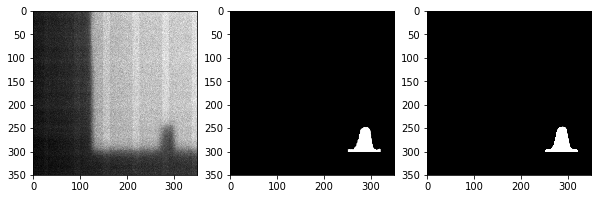

2: true_dist: 4, pred_dist: [3.7834148]


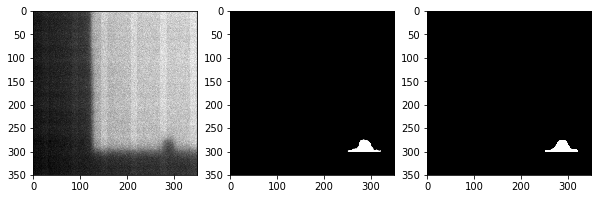

3: true_dist: 4, pred_dist: [3.9280515]


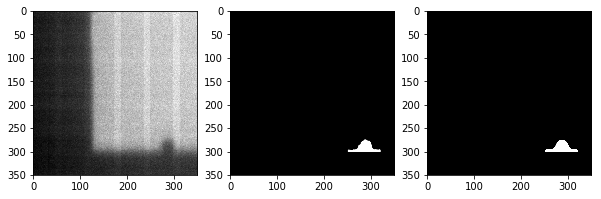

4: true_dist: 25, pred_dist: [25.00794]


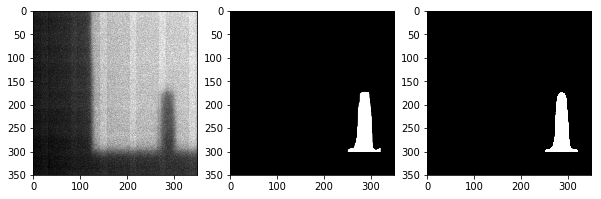

5: true_dist: 10, pred_dist: [10.030643]


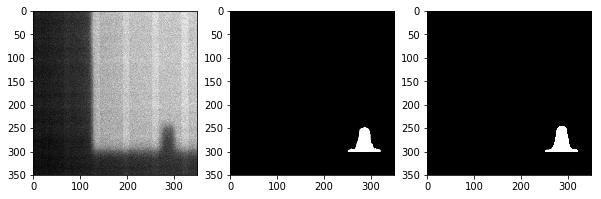

6: true_dist: 10, pred_dist: [9.961207]


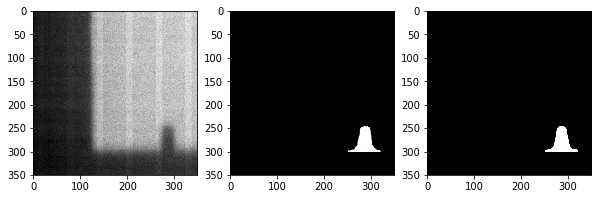

7: true_dist: 10, pred_dist: [9.969916]


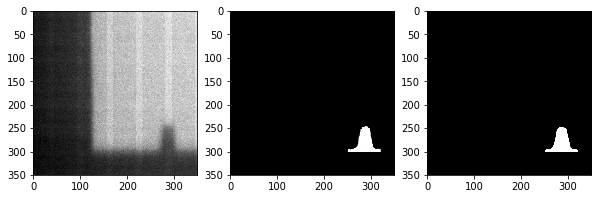

8: true_dist: 25, pred_dist: [24.888287]


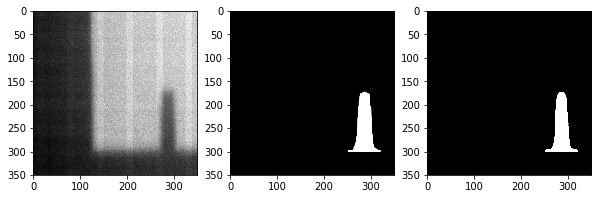

9: true_dist: 4, pred_dist: [3.807196]


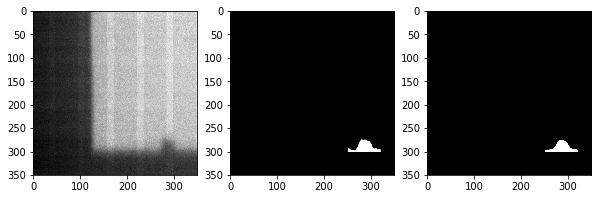

10: true_dist: 4, pred_dist: [3.752995]


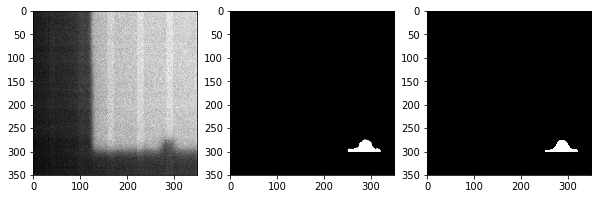

11: true_dist: 25, pred_dist: [25.001513]


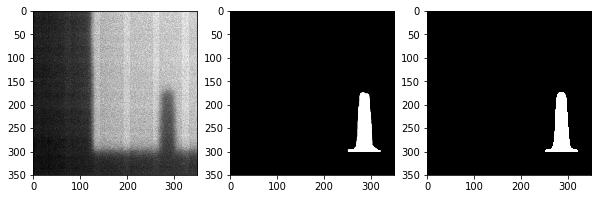

12: true_dist: 25, pred_dist: [25.104534]


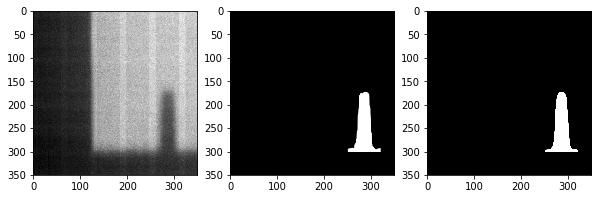

13: true_dist: 4, pred_dist: [3.906179]


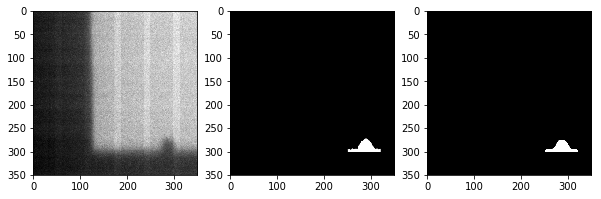

14: true_dist: 4, pred_dist: [3.8340533]


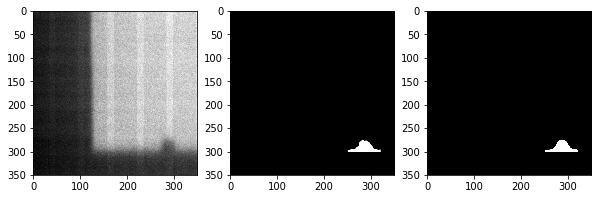

15: true_dist: 4, pred_dist: [3.8677144]


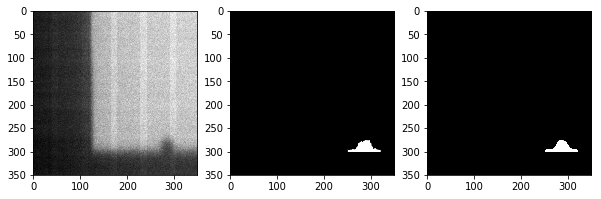

16: true_dist: 10, pred_dist: [10.161213]


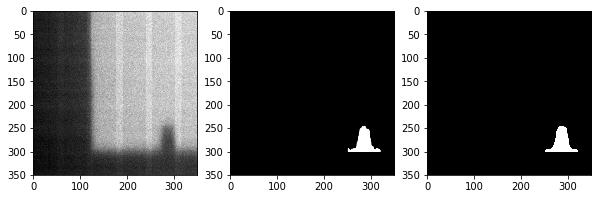

batch 2
1: true_dist: 25, pred_dist: [24.889294]


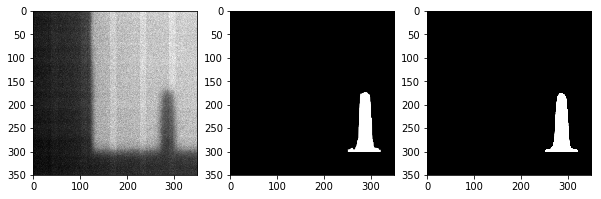

2: true_dist: 25, pred_dist: [24.901123]


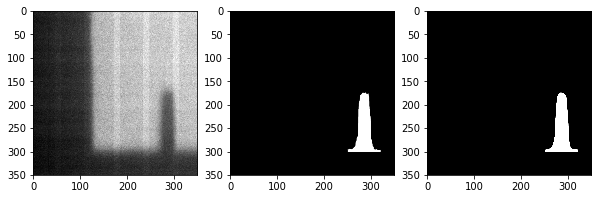

3: true_dist: 4, pred_dist: [3.9508507]


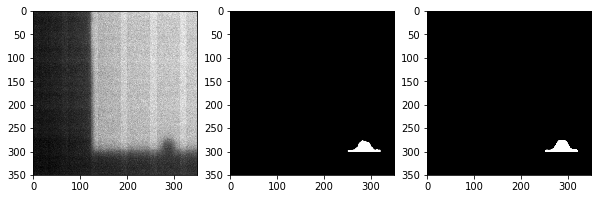

4: true_dist: 2, pred_dist: [2.123066]


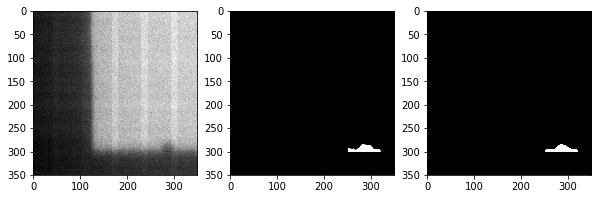

5: true_dist: 10, pred_dist: [10.194121]


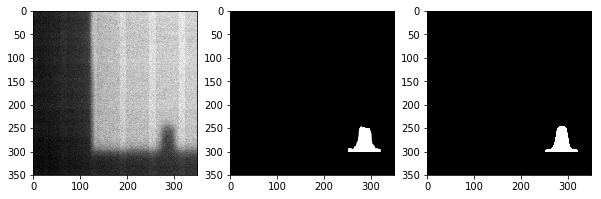

6: true_dist: 4, pred_dist: [3.7987125]


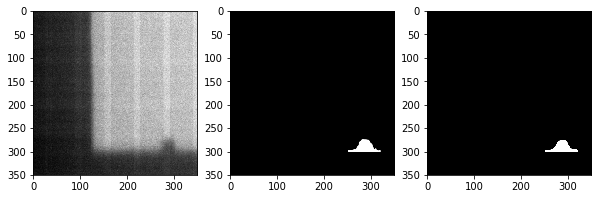

7: true_dist: 25, pred_dist: [25.16387]


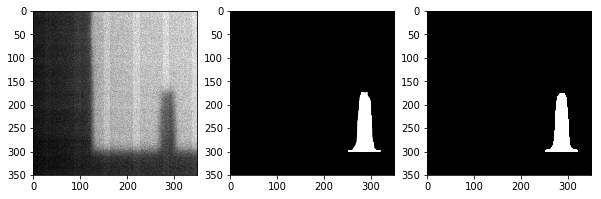

8: true_dist: 2, pred_dist: [2.1185079]


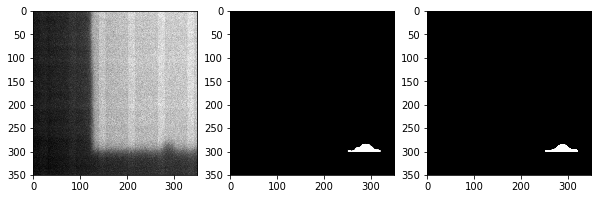

9: true_dist: 2, pred_dist: [2.190214]


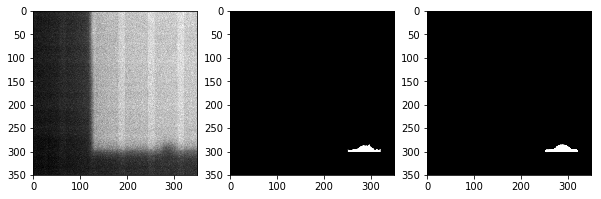

10: true_dist: 25, pred_dist: [24.88096]


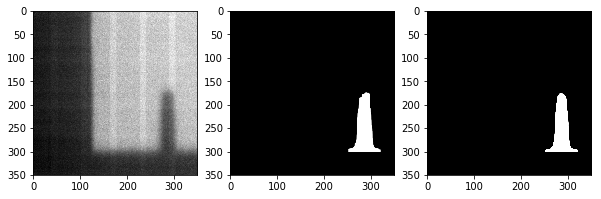

11: true_dist: 10, pred_dist: [10.034647]


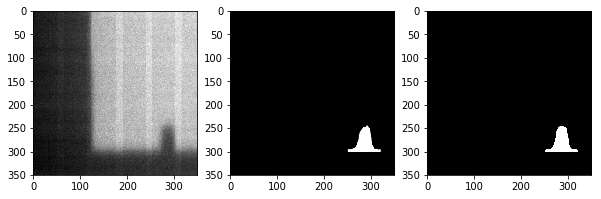

12: true_dist: 25, pred_dist: [24.843437]


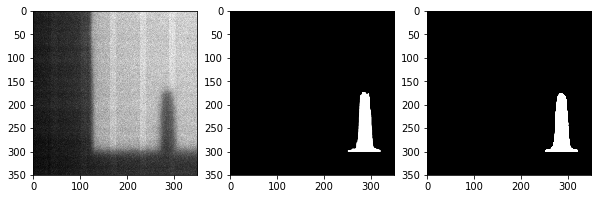

13: true_dist: 25, pred_dist: [24.844952]


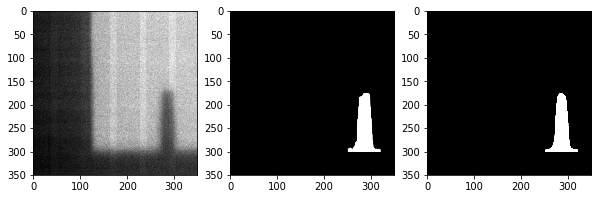

14: true_dist: 4, pred_dist: [3.9603791]


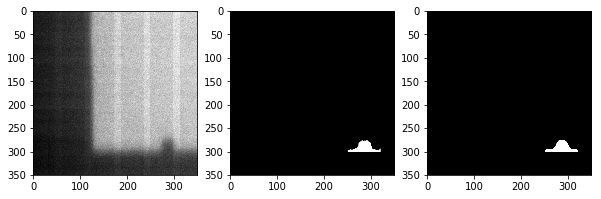

15: true_dist: 4, pred_dist: [3.8356864]


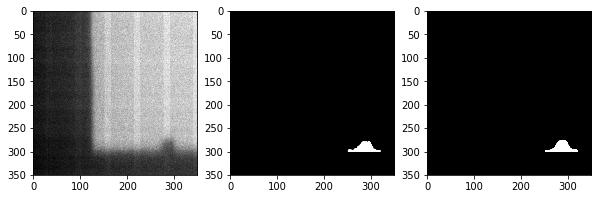

16: true_dist: 2, pred_dist: [2.1070716]


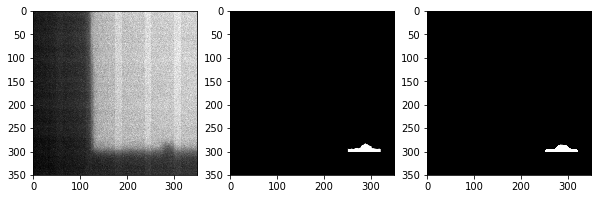

In [30]:
for i, batch in enumerate(test_data_loader):

    true_images, true_masks, true_dists = batch['image'], batch['mask'], batch['dist']
    pred_masks, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_msk, tr_cl, pr_msk, pr_cl) in enumerate(zip(true_images,
                                                 true_masks, 
                                                 true_dists.cpu().detach().numpy(),
                                                 pred_masks.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        print("{}: true_dist: {}, pred_dist: {}".format(j+1, true_dist, pred_dist))
        
        f = plt.figure(figsize=(10,5))
        f.add_subplot(1,3, 1)
        plt.imshow(img[0,...], cmap='gray')
        f.add_subplot(1,3, 2)
        plt.imshow(tr_msk[0,...], cmap='gray')
        f.add_subplot(1,3, 3)
        plt.imshow(pr_msk[0,...], cmap='gray')
        plt.show(block=True)
        
    if i==1:
        break

In [31]:
y_test = []
y_pred = []
for i, batch in enumerate(test_data_loader):
    true_images, true_dists = batch['image'], batch['dist']
    _, pred_classes = model_inference(true_images.float().to(device))
    print("batch {}".format(i+1))
    for j, (img, tr_cl, pr_cl) in enumerate(zip(true_images,
                                                 true_dists.cpu().detach().numpy(), 
                                                 pred_classes.cpu().detach().numpy())):
    
        true_dist = tr_cl
        pred_dist = pr_cl
        y_test.append(true_dist)
        y_pred.append(pred_dist)

batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15


In [32]:
15*16

240

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [34]:
mean_squared_error(y_test, y_pred)

0.015613592061621518

In [35]:
mean_absolute_error(y_test, y_pred)

0.10359231233596802